In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
pd.set_option("display.precision", 3)
InteractiveShell.ast_node_interactivity = "all"
import pickle
import os

# Extra imports
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

def multiclass_confusion(y_pred, y_true):
    ### Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    ## Get Class Labels
    labels = set(y_true)
    class_names = sorted(labels)

    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sn.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)
    plt.show()

def prepare_data(dataframe, variables=None, num_scaling = True):
    x = dataframe.loc[:, dataframe.columns != 'SUSPECT_RACE_DESCRIPTION']
    y = dataframe.loc[:, 'SUSPECT_RACE_DESCRIPTION']
    X_train, X_test, y_train, y_test =\
        train_test_split(x,y, test_size=0.2, random_state=14, stratify=y)
    if variables is not None:
        X_train = X_train.loc[:,variables]
        X_test = X_test.loc[:,variables]
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)
    X_train, X_test = X_train.align(X_test, join='inner', axis=1, fill_value=0)
    numericals = []
    for idx, types in enumerate(X_train.dtypes):
        if types == 'int64':
            numericals.append(X_train.columns[idx])
    if num_scaling:
        ct = ColumnTransformer([
                ('somename', StandardScaler(), numericals)
            ], remainder='passthrough')

        ct.fit_transform(X_train)
        ct.fit_transform(X_test)
    return X_train, X_test, y_train, y_test

np.random.seed(14)

In [2]:
local_dir = os.getcwd()
#data_path = COSTUM_DATA_LOCATION
#model_path = COSTUM_MODEL_LOCATION
data_path = os.path.join(os.path.dirname(os.path.dirname(local_dir)),'data')
model_path = os.path.join(os.path.dirname(local_dir),'models')

In [3]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=14)

Best MLP model

c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=[9],
              max_iter=500, random_state=14)

Confusion matrix of the TRAIN dataset


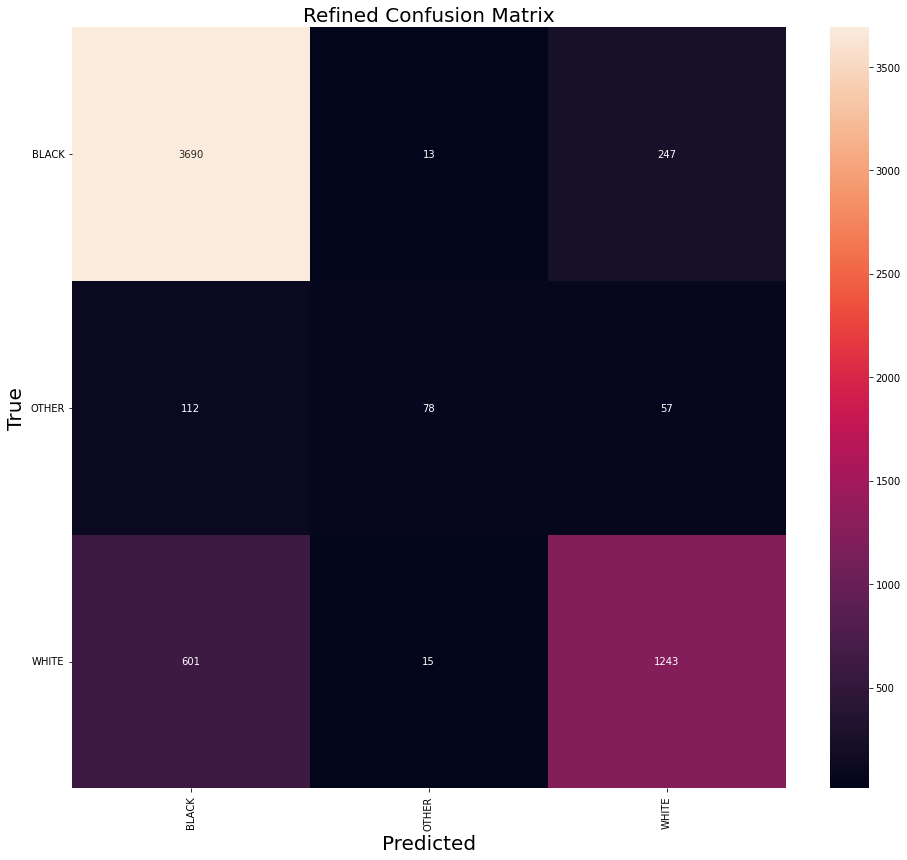

Confusion matrix of the TEST dataset


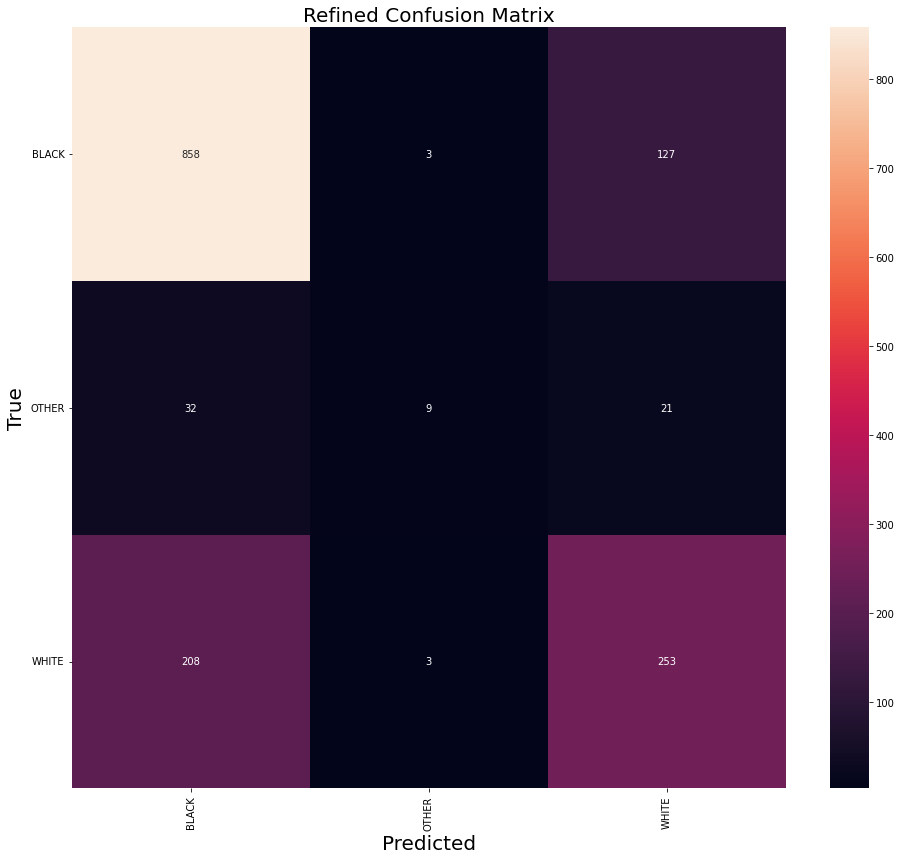

Macro F1: 0.547121456474756
The model predicts "Black" with 0.822627037392138 accuracy, "Other" with 0.2337662337662338 accuracy and "White" with 0.5849710982658959 accuracy


In [27]:
df = pd.read_csv(os.path.join(data_path,"train_preprocessed.csv"), index_col=0)
df['KMEANS_DEMEANOR'] = pd.Categorical(df['KMEANS_DEMEANOR'])

vars_to_keep = ['STOP_LOCATION_ZIP_CODE','SUSPECT_HAIR_COLOR','SUSPECT_EYE_COLOR'
,'STOP_LOCATION_BORO_NAME','SUSPECTED_CRIME_DESCRIPTION','FRISKED_FLAG','SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG','SUSPECT_ARREST_OFFENSE'	
,'BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG','FIREARM_FLAG','SUSPECT_BODY_BUILD_TYPE','BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG'	
,'OTHER_WEAPON_FLAG','WEAPON_FOUND_FLAG','VERBAL_IDENTIFIES_OFFICER_FLAG','SUSPECTS_ACTIONS_CASING_FLAG','SUPERVISING_OFFICER_RANK','DEMEANOR_CODE','MONTH2'
,'OFFICER_IN_UNIFORM_FLAG','SUSPECT_ARRESTED_FLAG','STOP_WAS_INITIATED','SEARCH_BASIS_HARD_OBJECT_FLAG','SEARCHED_FLAG','SUSPECT_SEX','OTHER_CONTRABAND_FLAG'	
,'SEARCH_BASIS_CONSENT_FLAG','IMMEDIATE_STOP_FLAG','STOP_DURATION_MINUTES','SUSPECT_REPORTED_AGE','SUSPECT_HEIGHT','SUSPECT_WEIGHT','KMEANS_DEMEANOR']

X_train, X_test, y_train, y_test = prepare_data(df, vars_to_keep)

model_best = MLPClassifier(hidden_layer_sizes=[9],
                           alpha=0.00001,
                           activation='logistic',
                           max_iter=500,
                           solver='adam',random_state=14)

model_best.fit(X_train, y_train)
y_pred = model_best.predict(X_train)
y_pred_test = model_best.predict(X_test)

print('Confusion matrix of the TRAIN dataset')
multiclass_confusion(y_pred,y_train)

print('Confusion matrix of the TEST dataset')
multiclass_confusion( y_pred_test,y_test)

macro_f1 = f1_score(y_test, y_pred_test, average='macro')
print('Macro F1: {}'.format(macro_f1))

micro_f1 = f1_score(y_test, y_pred_test, average=None)
print('The model predicts "Black" with {} accuracy, "Other" with {} accuracy and "White" with {} accuracy'.format(micro_f1[0], micro_f1[1],micro_f1[2]))

In [ ]:
filename = 'final_MLP.model'
pickle.dump(model_best, open(os.path.join(model_path,filename), 'wb'))

best kernel model

Confusion matrix of the TEST dataset


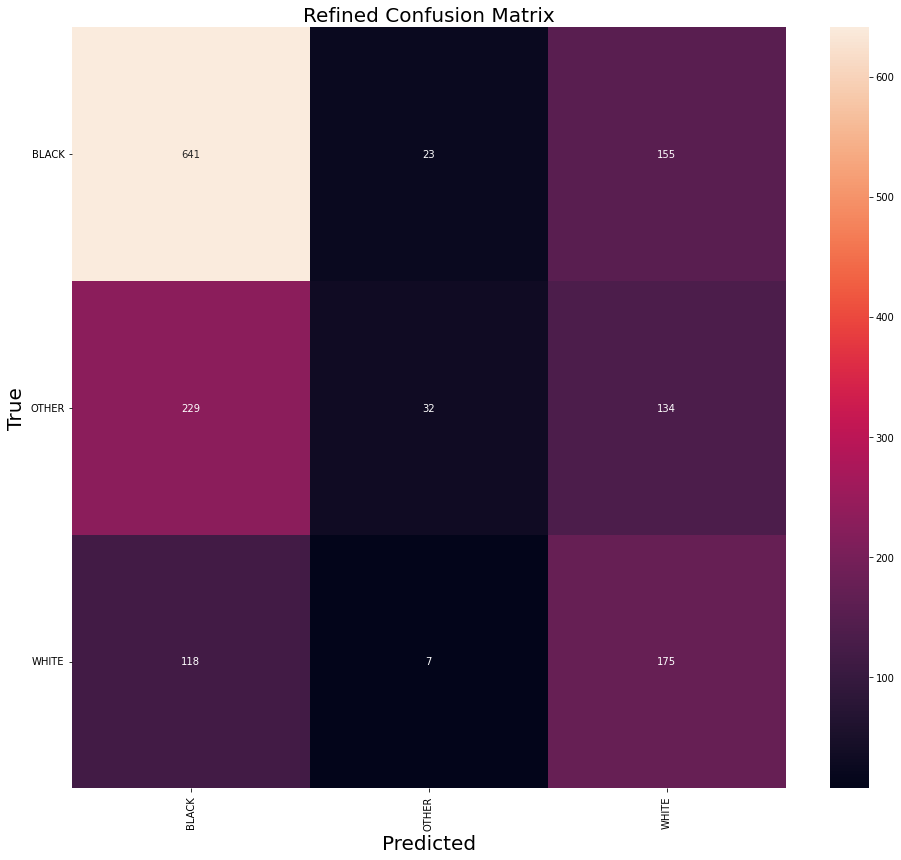

Macro F1: 0.4358740485313513
The model predicts "Black" with 0.7094631986718318 accuracy, "Other" with 0.1400437636761488 accuracy and "White" with 0.45811518324607337 accuracy


In [21]:
df = pd.read_csv(os.path.join(data_path,"train_preprocessed_final_noMCA.csv"), index_col=0)
df['KMEANS_DEMEANOR'] = pd.Categorical(df['KMEANS_DEMEANOR'])

X_train, X_test, y_train, y_test = prepare_data(df, num_scaling=False)

final_svm = svm.SVC(kernel='poly', cache_size = 1000, degree=1, C=0.1, gamma = 10, coef0 = 1, decision_function_shape='ovo', class_weight="balanced", random_state = 14).fit(X_train, y_train)

y_pred_test = final_svm.predict(X_test)

print('Confusion matrix of the TEST dataset')
multiclass_confusion(y_test, y_pred_test)

macro_f1 = f1_score(y_test, y_pred_test, average='macro')
print('Macro F1: {}'.format(macro_f1))

micro_f1 = f1_score(y_test, y_pred_test, average=None)
print('The model predicts "Black" with {} accuracy, "Other" with {} accuracy and "White" with {} accuracy'.format(micro_f1[0], micro_f1[1],micro_f1[2]))

In [22]:
filename = 'final_SVM.model'
pickle.dump(model_best, open(os.path.join(model_path,filename), 'wb'))

best tree model

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=20, min_samples_leaf=4, n_estimators=200,
                       random_state=18)

Confusion matrix of the TEST dataset


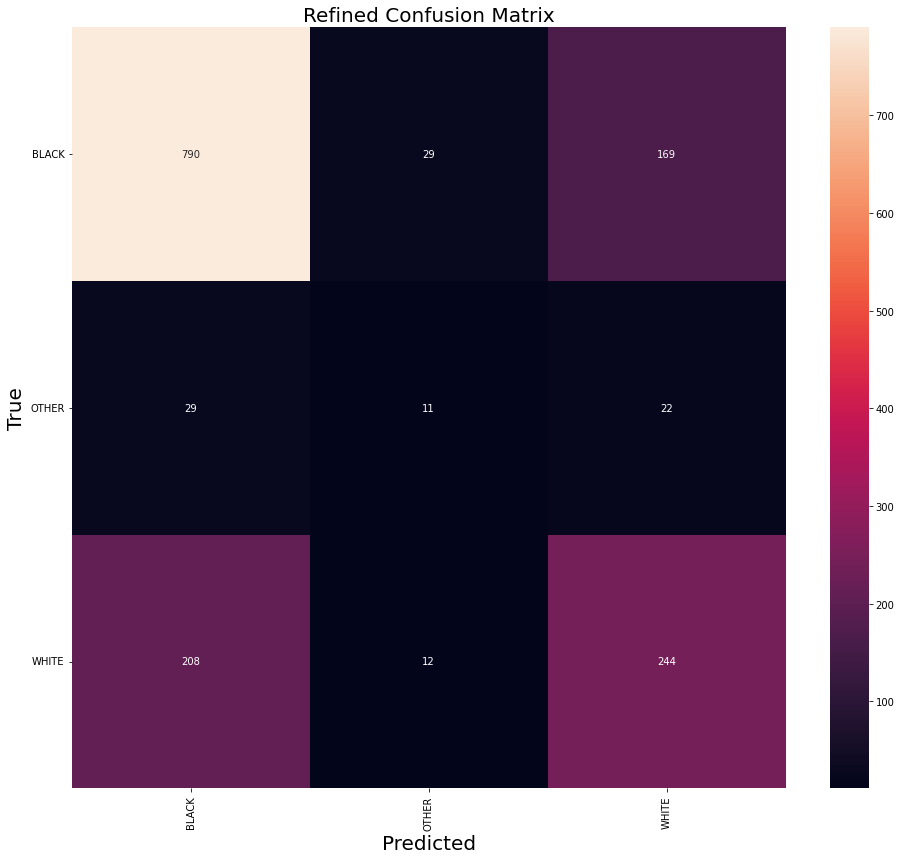

Macro F1: 0.5066423081176317
The model predicts "Black" with 0.7841191066997519 accuracy, "Other" with 0.1929824561403509 accuracy and "White" with 0.542825361512792 accuracy


In [28]:
df = pd.read_csv(os.path.join(data_path,"train_preprocessed_final_noMCA.csv"), index_col=0)
df['KMEANS_DEMEANOR'] = pd.Categorical(df['KMEANS_DEMEANOR'])

X_train, X_test, y_train, y_test = prepare_data(df, num_scaling=False)

best_params = {'bootstrap': False,
 'class_weight': 'balanced_subsample',
 'max_depth': 20,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200}
best_rf_tuned = RandomForestClassifier(**best_params, random_state = 18)
best_rf_tuned.fit(X_train, y_train)

y_pred = best_rf_tuned.predict(X_test)

print('Confusion matrix of the TEST dataset')
multiclass_confusion(y_pred,y_test)

macro_f1 = f1_score(y_test, y_pred, average='macro')
print('Macro F1: {}'.format(macro_f1))

micro_f1 = f1_score(y_test, y_pred, average=None)
print('The model predicts "Black" with {} accuracy, "Other" with {} accuracy and "White" with {} accuracy'.format(micro_f1[0], micro_f1[1],micro_f1[2]))

In [29]:
filename = 'final_RF.model'
pickle.dump(best_rf_tuned, open(os.path.join(model_path,filename), 'wb'))